### Imports

In [1]:
import time
import sympy as sp
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.linalg import det
from itertools import combinations
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import rsa, padding

### Funciones para generar los vectores

In [2]:
def angle_vectors(vector1, vector2):
    vector1_norm = vector1 / np.linalg.norm(vector1)
    vector2_norm = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(vector1_norm, vector2_norm)
    angle_rad = np.arccos(np.clip(dot_product, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    angle_deg = angle_deg if angle_deg <= 180 else 360 - angle_deg
    return angle_deg

def vector_generator(dim, norma_maxima, mode="ortogonal", margen = 90, matrix=None):
    if mode not in ["good", "bad", "ortogonal"]:
        raise ValueError("Modos aceptados: 'good', 'bad'.")
    if mode == "ortogonal":
        return np.eye(dim), None
    if matrix is None:
        matrix = np.random.randint(-norma_maxima, norma_maxima + 1, size=(dim, dim))
    index_vectors = set(range(dim))
    vectors2review = list(combinations(index_vectors, len(index_vectors) - 1))
    vectors2review.reverse()
    comb_vectors = [(index, comb) for index, comb in zip(index_vectors, vectors2review)]
    angles_total = dict()
    for i, comb in comb_vectors:
        while np.all(matrix[i] == 0) or not i in sp.Matrix(matrix).T.rref()[1]:
            matrix[i] = np.random.randint(-norma_maxima, norma_maxima + 1, size=dim)
        while True:
            angles_array = dict()
            for j in comb:
                # print(matrix, i, j, matrix[i], matrix[j], angles_array)
                if np.all(matrix[i] == 0):
                    # print(f"{matrix[i]}, Vector nulo. Generando nuevo vector...")
                    matrix[i] = np.random.randint(-norma_maxima, norma_maxima + 1, size=dim)
                    i, j = 0, 1
                if i in sp.Matrix(matrix).T.rref()[1]:
                    # print(f"{matrix[i]} No nulo. Vectores linealmente independiente. Revisando ángulos...")
                    angle = angle_vectors(matrix[i], matrix[j])
                    angles_array[f"<{matrix[j]}"] = angle
                    # print(angles_array, angle)
                    # print(f"Ángulo entre {matrix[i]} y {matrix[j]}: {angle}")
                    if mode == "good":
                        margen = margen
                        validAngle = (90 - margen < angle < 90 + margen)
                    elif mode == "bad":
                        margen = margen
                        validAngle = (angle < 90 - margen or angle > 90 + margen)
                    if not validAngle:
                        # print(f"Ángulo inválido.")
                        matrix[i] = np.random.randint(-norma_maxima, norma_maxima + 1, size=dim)
                    # else:
                        # print(f"Ángulo válido.")
                else:
                    # print(f"{matrix[i]}, Linealmente dependiente. {sp.Matrix(matrix).T.rref()[1]}. Generando nuevo vector...")
                    matrix[i] = np.random.randint(-norma_maxima, norma_maxima + 1, size=dim)
            if mode == "good":
                True_list = [True if 90 - margen < valor < 90 + margen else False for _, valor in angles_array.items()]
            elif mode == "bad":
                True_list = [True if valor < 90 - margen or valor > 90 + margen else False for _, valor in angles_array.items()]
            if all(True_list):
                angles_total[f"{matrix[i]}"] = angles_array
                break
    return matrix, angles_total

def review_matrix(dim, matrix, mode):
    for i in range(dim - 1):
        for j in range(dim - 1):
            if i == j:
                continue
            angle = angle_vectors(matrix[i], matrix[j])
            is_null = np.all(matrix[j] == 0)
            is_notLinear = not j in sp.Matrix(matrix).T.rref()[1]
            if mode == "good":
                margen = 20
                not_validAngle = not (90 - margen < angle < 90 + margen)
            elif mode == "bad":
                margen = 40
                not_validAngle = not (90 - margen > angle < 90 + margen)
            if is_null or is_notLinear or not_validAngle:
                return False
    return True

def lattice_generator(size_lattice, vectores):
    """
    Dibuja puntos en el plano y los vectores iniciales.

    Parámetros:
    - vectores: Vectores iniciales.
    - size_lattice: Rango de valores enteros para las combinaciones lineales.

    """
    # Generar todas las combinaciones lineales de enteros de los vectores
    puntos = []
    sorted_matrix = sorted(vectores, key=lambda punto: np.linalg.norm(punto))
    for i in range(- size_lattice, size_lattice + 1):
        for j in range(- size_lattice, size_lattice + 1):
            punto = i * np.array(sorted_matrix[0]) + j * np.array(sorted_matrix[1])
            puntos.append(punto)
            if np.all(punto == 0):
                continue
    return puntos, size_lattice

def print_matrix(matrix, labels):
    for vector, label in zip(matrix, labels):
        print(f"{label}: {vector.tolist()}")

### Funciones para graficar

In [3]:
def draw_matrix(matrix, labels, point_msg=None):
    dim = matrix.shape[1]
    colores = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']

    if dim == 2:
        fig, ax = plt.subplots()
        for i, vector in enumerate(matrix):
            ax.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=colores[i % len(colores)],
                      label=f"{labels[i]}: {vector.tolist()}")
        max_val = np.max(np.abs(matrix))
        if point_msg is not None:
            ax.plot(point_msg[0], point_msg[1], marker='o', markersize=8, color=colores[len(vector)],
                    label=f'Msg coded: {point_msg.tolist()}')
            max_val = max(max_val, np.max(np.abs(point_msg)))

        # Asegurar que el espacio entre las marcas de los ejes sea igual y la figura sea cuadrada
        ax.set_xlim(-max_val - 1, max_val + 1)
        ax.set_ylim(-max_val - 1, max_val + 1)
        ax.set_aspect('equal', adjustable='box')  # Ajustar la proporción de los ejes
        ax.set_xlabel('Eje X')
        ax.set_ylabel('Eje Y')
        ax.grid()
        ax.legend()
        plt.show()

    elif dim == 3:
        fig = go.Figure()
        for i, vector in enumerate(matrix):
            fig.add_trace(go.Scatter3d(x=[0, vector[0]], y=[0, vector[1]], z=[0, vector[2]],
                                       mode='lines', line=dict(color=colores[i % len(colores)], width=2),
                                       name=f"{labels[i]}: {vector.tolist()}"))
        max_val = np.max(np.abs(matrix))
        if point_msg is not None:
            fig.add_trace(go.Scatter3d(x=[point_msg[0]], y=[point_msg[1]], z=[point_msg[2]],
                                       mode='markers', marker=dict(color=colores[len(vector)], size=8),
                                       name=f'Msg coded: {point_msg.tolist()}'))
            max_val = max(max_val, np.max(np.abs(point_msg)))

        # Asegurar que el espacio entre las marcas de los ejes sea igual y la figura sea cuadrada
        fig.update_layout(scene=dict(xaxis_range=[-max_val - 1, max_val + 1],
                                     yaxis_range=[-max_val - 1, max_val + 1],
                                     zaxis_range=[-max_val - 1, max_val + 1],
                                     xaxis_title='Eje X', yaxis_title='Eje Y', zaxis_title='Eje Z'),
                          showlegend=True, scene_camera=dict(eye=dict(x=1.2, y=1.2, z=1.2)))
        fig.show()
    else:
        print("El número de dimensiones no permite generar una gráfica.")


def draw_lattice(matrix, labels, puntos, max_axis):
    # Extraer las coordenadas x e y de los puntos
    x, y = zip(*puntos)
    # Crear una figura y especificar el tamaño
    plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus necesidades
    # Dibujar los puntos en el plano
    plt.scatter(x, y, marker='o', label='Combinaciones Lineales')
    # Dibujar los vectores iniciales
    colors = ['red', 'blue', 'green', 'orange']
    for vector, label, color in zip(matrix, labels, colors):
        plt.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=color, label=label)

    # Configurar el gráfico    
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.title('Combinaciones Lineales de Vectores')
    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.legend()
    
    # # Ajustar el rango visible en la figura
    
    plt.xlim(- max_axis, max_axis)
    plt.ylim(- max_axis, max_axis)

    # Mostrar el gráfico
    plt.show()

### Funciones de cifrado y descifrado

In [4]:
def random_unimodular_matrix(n, max_value = 10):
    lower_triangular = np.tril(np.random.randint(-max_value, max_value, size=(n, n)), k=-1)
    np.fill_diagonal(lower_triangular, 1)
    upper_triangular = np.triu(np.random.randint(-max_value, max_value, size=(n, n)), k=1)
    np.fill_diagonal(upper_triangular, 1)
    unimodular_matrix = np.dot(lower_triangular, upper_triangular).astype(np.float64)
    return unimodular_matrix

def base_publica(base_privada, unimodular_matrix):
    return np.dot(unimodular_matrix, base_privada)

def cifrar_mensaje(base_publica, vector_ruido, vector_mensaje):
    crypt_mgs = np.dot(vector_mensaje, base_publica) + vector_ruido
    return crypt_mgs

def descifrar_mensaje(base_privada, unimodular_matrix, crypt_mgs):
    inv_base_privada = invertir_matriz(base_privada)
    inv_unimodular_matrix = invertir_matriz(unimodular_matrix)
    decrypt_mgs = np.dot(np.round(np.dot(crypt_mgs, inv_base_privada)), inv_unimodular_matrix)
    return decrypt_mgs

def vectorizar_mensaje(mensaje):
    vector_mensaje = np.array([ord(caracter) for caracter in mensaje])
    return vector_mensaje

def desvectorizar_mensaje(vector_mensaje):
    mensaje = ''.join(chr(int(round(entero))) for entero in vector_mensaje)
    return mensaje

def invertir_matriz(matriz):
    matriz_np = np.array(matriz)
    matriz_invertida = np.linalg.inv(matriz_np)
    return matriz_invertida

def generar_valores_aleatorios(n, media = 0, std_dev = 1):
    valores_normal = np.random.normal(loc=media, scale=std_dev, size=n)
    return valores_normal

### Main code

In [5]:
dimensiones = 5     # Dimensiones de la matriz (Se extiende si el mensaje es de mayor longitud)
mensaje = "IPD438"  # Mensaje a cifrar

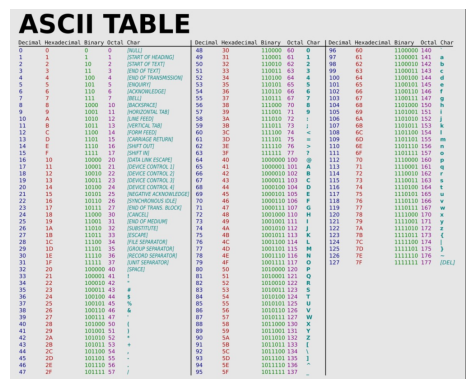

Mensaje original: [73 80 68 52 51 56]
Mensaje relleno: [73 80 68 52 51 56]
V. Privado 1: [-13, -13, 2, -6, 0, -2]
V. Privado 2: [14, -13, 9, -4, -12, -2]
V. Privado 3: [-2, -3, 5, 13, -7, 7]
V. Privado 4: [-7, 8, -9, -5, -15, -7]
V. Privado 5: [0, 7, 6, -8, -4, 13]
V. Privado 6: [7, -11, -15, 2, 0, 9]
El número de dimensiones no permite generar una gráfica.


In [6]:
modes = {"good": 10, "bad": 50, "ortogonal": None}

# Ejemplo de uso

ascii_table = mpimg.imread('ascii_table.jpg')
plt.imshow(ascii_table)
plt.axis('off')
plt.show()
ascii_mensaje = vectorizar_mensaje(mensaje)
nro_caracteres = len(mensaje)
if nro_caracteres <= dimensiones:
    zeros2fill = dimensiones - len(ascii_mensaje)
else:
    zeros2fill = 0
    dimensiones = nro_caracteres

print(f"Mensaje original: {ascii_mensaje}")
ascii_mensaje = np.concatenate([ascii_mensaje, np.zeros(zeros2fill, dtype=int)])
print(f"Mensaje relleno: {ascii_mensaje}")

norma_maxima = 15
mode = list(modes.keys())[0]

priv_labels = [f"V. Privado {i + 1}" for i in range(dimensiones)]
pub_labels = [f"V. Publico {i + 1}" for i in range(dimensiones)]

base_priv, angles_betVectors = vector_generator(dimensiones, norma_maxima, mode, modes[mode])
print_matrix(base_priv, priv_labels)
draw_matrix(base_priv, base_priv, np.array([2, 3, 3]))
# print(base_priv.tolist(), angles_betVectors)

In [7]:
print(f"Mensaje original (texto plano):\n{mensaje}")
print(f"Mensaje ASCII:\n{ascii_mensaje}")
print(f"Base privada:\n{base_priv}")

Mensaje original (texto plano):
IPD438
Mensaje ASCII:
[73 80 68 52 51 56]
Base privada:
[[-13 -13   2  -6   0  -2]
 [ 14 -13   9  -4 -12  -2]
 [ -2  -3   5  13  -7   7]
 [ -7   8  -9  -5 -15  -7]
 [  0   7   6  -8  -4  13]
 [  7 -11 -15   2   0   9]]


In [8]:
unimodular_matrix   = random_unimodular_matrix(dimensiones, 5)
b_publica           = base_publica(base_priv, unimodular_matrix)
print(f"Matriz unimodular:\n{unimodular_matrix}")
print(f"Base pública:\n{b_publica}")

Matriz unimodular:
[[  1.  -2.   3.   4.   4.   4.]
 [  4.  -7.   9.  18.  11.  16.]
 [  3.  -3.   1.  20.  -4.  15.]
 [ -2.   6.  -8.   5. -23.   5.]
 [  1.  -3.   9.   7.   8.   9.]
 [ -4.   6.  -4. -12.  -9. -14.]]
Base pública:
[[ -47.   20.  -73.   -3.  -73.   83.]
 [-182.   57. -346.  -25. -293.  230.]
 [-118.  -36. -445.  -31. -255.  -50.]
 [ 126. -204. -248.   53.    1. -353.]
 [ -59.   12. -130.   42. -164.  203.]
 [ 130.  -19.  290.   52.  172. -191.]]


In [9]:
vector_ruido = generar_valores_aleatorios(dimensiones, 0, 1)
print(f"Vector ruido:\n{vector_ruido}")

Vector ruido:
[-1.18319109  1.57885901 -0.203465   -0.82750084 -2.11440732  0.16343986]


In [10]:
cipher = cifrar_mensaje(b_publica, vector_ruido, ascii_mensaje)
print(f"Mensaje cifrado:\n{cipher}")

Mensaje cifrado:
[-15193.18319109  -7486.42114099 -66555.203465     3482.17249916
 -44791.11440732   2360.16343986]


In [11]:
decrypt = descifrar_mensaje(base_priv, unimodular_matrix, cipher)
print(f"Mensaje descifrado:\n{decrypt}")

Mensaje descifrado:
[73. 80. 68. 52. 51. 56.]


In [12]:
reconstruct = desvectorizar_mensaje(decrypt)
print(f"Mensaje reconstruido: {reconstruct}")

Mensaje reconstruido: IPD438


In [22]:
def tiempo_Lattice(num_ciclos=100, norma_maxima=10, mode="ortogonal"):
    mensaje = "hola"
    tiempos_encriptacion = []
    tiempos_desencriptacion = []
    for _ in range(num_ciclos):
        # Encriptación
        ascii_mensaje = vectorizar_mensaje(mensaje)
        dimensiones = len(ascii_mensaje)
        matrix_priv, _ = vector_generator(dimensiones, norma_maxima, mode, modes[mode])
        unimodular_matrix = random_unimodular_matrix(dimensiones)
        vector_ruido = generar_valores_aleatorios(dimensiones, 0, 1)
        inicio_encriptacion = time.time()
        base_pub = base_publica(matrix_priv, unimodular_matrix)
        cipher = cifrar_mensaje(base_pub, vector_ruido, ascii_mensaje)
        fin_encriptacion = time.time()
        tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        tiempos_encriptacion.append(tiempo_encriptacion)

        # Desencriptación
        inicio_desencriptacion = time.time()
        _ = descifrar_mensaje(matrix_priv, unimodular_matrix, cipher)
        fin_desencriptacion = time.time()
        tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        tiempos_desencriptacion.append(tiempo_desencriptacion)
        mensaje += "a"

    # Graficar resultados
    ciclos = range(1, num_ciclos + 1)
    plt.plot(ciclos, tiempos_encriptacion, label='Encriptación')
    plt.plot(ciclos, tiempos_desencriptacion, label='Desencriptación')
    # Graficar la línea de tendencia

    plt.xlabel('Ciclo/Nro. de caracteres')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.title('Tiempo vs Nro. Caracteres. Retícula')
    plt.show()


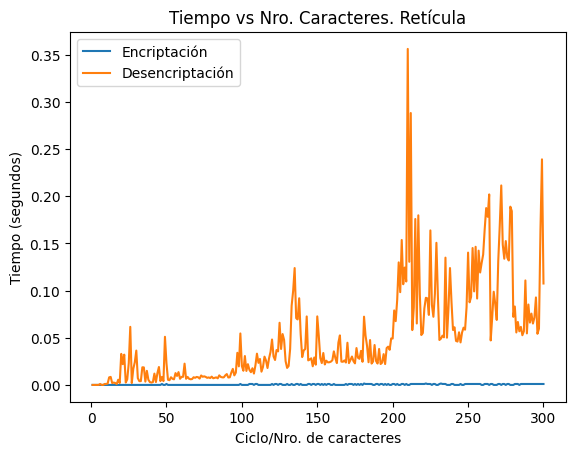

In [20]:
tiempo_Lattice(300, 10, "ortogonal")

### Cifrado En RSA

Ejemplo en RSA

In [23]:
def gcd(a, b):
    while b != 0:
        a, b = b, a % b
    return a

def modinv(a, m):
    m0, x0, x1 = m, 0, 1
    while a > 1:
        q = a // m
        m, a = a % m, m
        x0, x1 = x1 - q * x0, x0
    return x1 + m0 if x1 < 0 else x1

def is_prime(n, k=5):
    if n <= 1 or n == 4:
        return False
    if n <= 3:
        return True
    d = n - 1
    s = 0
    while d % 2 == 0:
        d //= 2
        s += 1
    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True

def generate_prime(bits):
    while True:
        num = random.getrandbits(bits)
        if is_prime(num):
            return num

def generate_keypair(message_length):
    bits = message_length * 8  # Asegura que el tamaño de la clave sea suficiente para el mensaje
    p = generate_prime(bits)
    q = generate_prime(bits)
    n = p * q
    phi = (p - 1) * (q - 1)
    
    e = 65537  # Common choice for the public exponent
    while gcd(e, phi) != 1:
        e = random.randrange(2, phi)

    d = modinv(e, phi)
    return ((n, e), (n, d))

def encrypt(message, public_key):
    n, e = public_key
    cipher = [pow(ord(char), e, n) for char in message]
    return cipher

def decrypt(cipher, private_key):
    n, d = private_key
    message = ''.join([chr(pow(char, d, n)) for char in cipher])
    return message

mensaje = "Hola mundo!"

clave_publica, clave_privada = generate_keypair(len(mensaje))
mensaje_encriptado = encrypt(mensaje, clave_publica)
mensaje_desencriptado = decrypt(mensaje_encriptado, clave_privada)

print("Mensaje original:", mensaje)
print("Mensaje encriptado:", mensaje_encriptado)
print("Mensaje desencriptado:", mensaje_desencriptado)


Mensaje original: Hola mundo!
Mensaje encriptado: [40331676361655424005243878831080342093576090517783273, 11241171788148668069882295358275735176272220697037710, 19666108900758534862961763472603711504685511958166067, 21984679107108016407738447480164221656948308184649153, 8961798506497515943574756276296666247986519593871407, 23029394890518715022412055528724439519000877915667152, 6911148035408276833187062473920378635606094680271480, 14793051498699238470867020161520938721734804994523716, 38715585260194984384587344203899721013086525927725628, 11241171788148668069882295358275735176272220697037710, 30808085390273505023041471842011314403022945928508616]
Mensaje desencriptado: Hola mundo!


In [24]:
def generar_claves():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()

    private_pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    )

    public_pem = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )

    return private_pem, public_pem

def cifrar(mensaje, clave_publica):
    public_key = serialization.load_pem_public_key(clave_publica, backend=default_backend())
    cifrado = public_key.encrypt(
        mensaje.encode(),
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return cifrado

def descifrar(mensaje_cifrado, clave_privada):
    private_key = serialization.load_pem_private_key(clave_privada, password=None, backend=default_backend())
    mensaje = private_key.decrypt(
        mensaje_cifrado,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return mensaje.decode()

mensaje_original = "Hola mundo!"
clave_privada, clave_publica = generar_claves()
print("Mensaje original:", mensaje)
mensaje_cifrado = cifrar(mensaje_original, clave_publica)
print(f"Mensaje cifrado: {mensaje_cifrado}")
mensaje_descifrado = descifrar(mensaje_cifrado, clave_privada)
print(f"Mensaje descifrado: {mensaje_descifrado}")


Mensaje original: Hola mundo!
Mensaje cifrado: b'G\xbd\x16<\xe6\xf1\x18<\xfe\xbe3\x0c\'\xa0-R sfk)\x13\x8ai\xf2\xa8\x1b\x00\x13\xbd\x98\xb2\xc6\x11P\x01\xb5 p?\x97Q\xb4e\xbbe\xf4\xd6\xe7P\xa1\x8a\x9f\x0e\xb2[\xae\xb5\xc0\xa4\xb5\x9c~\xc2\xb7\xf8\xfes\xb2\x8dcA_\x18K,\x99\xceJ[3\r\x03\xd3\xa6\xa4\xdb\x19\xff\x00\xe7\xf0\x8d\xd7WX\xc9\xe1\r:\xe5\xba\x05\xbb&\xac\xaf\x1b\xdc\xdaP6\x04\x18\xa7T\xd0\xcf9[\xccMHP\x82+\xa8\x10e\xaf\xe1SH\xcd\x94\x1a\x9e\x1d&\x98\x95b;\x92hN\xcd\xff(\xa82k\x1a[\x90\xce\xf4\xf7\xe8\x87G\tKA\x9bd+\x116tS\xee\xc4\xe1g5\xa9\xf2=\xed4-g\x91\xd6"=\xaf;\x06.\x7f\x0eV1 \x80Ml\xa3\xefA\xd8\x1c\x87\xe0j\x1a\xfc\xc7\xae \xd5\xad\xf2~\xf2i\xf5|\x0e\xad\x80\x10C\x8b%\xdf\x07\x0fW\x9d5\x81"~\x8e\x9e:\xc9\x7fr\x93T\x1aWg\x8b\xb2\xd5\x1d\xa1%\xd5\xe8 '
Mensaje descifrado: Hola mundo!


In [25]:
def tiempo_RSA(num_ciclos = 10):
    mensaje = "hola"
    encriptacion_RSA = []
    desencriptacion_RSA = []

    for _ in range(num_ciclos):
        clave_publica, clave_privada = generate_keypair(len(mensaje))
        # Encriptación
        inicio_encriptacion = time.time()
        mensaje_encriptado = encrypt(mensaje, clave_publica)
        fin_encriptacion = time.time()
        tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        encriptacion_RSA.append(tiempo_encriptacion)

        # Desencriptación
        inicio_desencriptacion = time.time()
        _ = decrypt(mensaje_encriptado, clave_privada)
        fin_desencriptacion = time.time()
        tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        desencriptacion_RSA.append(tiempo_desencriptacion)
        mensaje += "a"

    # Graficar resultados
    plt.plot(range(1, num_ciclos + 1), encriptacion_RSA, label='Encriptación')
    plt.plot(range(1, num_ciclos + 1), desencriptacion_RSA, label='Desencriptación')
    plt.xlabel('Ciclo/Nro. de caracteres')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.title('Tiempo vs Nro. Caracteres: RSA Propio')
    plt.show()
    
def tiempo_RSA_lib(num_ciclos = 10):
    mensaje = "hola"
    encriptacion_RSA = []
    desencriptacion_RSA = []

    for _ in range(num_ciclos):
        # RSA biblioteca
        clave_privada, clave_publica = generar_claves()
        # Encriptación
        inicio_encriptacion = time.time()
        mensaje_encriptado = cifrar(mensaje, clave_publica)
        fin_encriptacion = time.time()
        tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        encriptacion_RSA.append(tiempo_encriptacion)

        # Desencriptación
        inicio_desencriptacion = time.time()
        _ = descifrar(mensaje_encriptado, clave_privada)
        fin_desencriptacion = time.time()
        tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        desencriptacion_RSA.append(tiempo_desencriptacion)
        mensaje += "a"

    # Graficar resultados
    plt.plot(range(1, num_ciclos + 1), encriptacion_RSA, label='Encriptación')
    plt.plot(range(1, num_ciclos + 1), desencriptacion_RSA, label='Desencriptación')
    plt.xlabel('Ciclo/Nro. de caracteres')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.title('Tiempo vs Nro. Caracteres: RSA Biblioteca (cryptography)')
    plt.show()


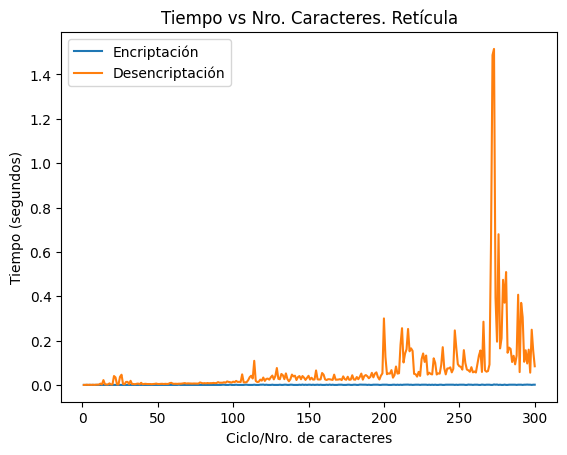

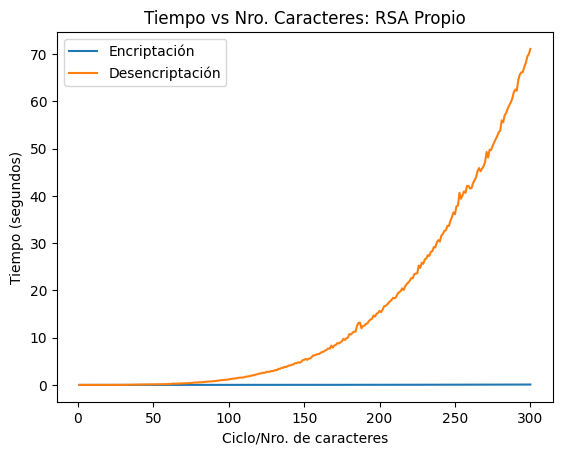

In [26]:
# Uso de la función
num_ciclos = 300
tiempo_Lattice(num_ciclos)
tiempo_RSA(num_ciclos)
# tiempo_RSA_lib(num_ciclos)

In [30]:
def Compare_Lattice_RSAs(num_ciclos = 10, norma_maxima=10, mode="ortogonal"):
    mensaje = "hola"
    encriptacion_RSA = []
    desencriptacion_RSA = []
    encriptacion_RSA_lib = []
    desencriptacion_RSA_lib = []
    encriptacion_reticulas = []
    desencriptacion_reticulas = []
    for _ in range(num_ciclos):
        # RSA
        clave_publica, clave_privada = generate_keypair(len(mensaje))
        # Encriptación
        inicio_encriptacion = time.time()
        mensaje_encriptado = encrypt(mensaje, clave_publica)
        fin_encriptacion = time.time()
        tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        encriptacion_RSA.append(tiempo_encriptacion)

        # Desencriptación
        inicio_desencriptacion = time.time()
        _ = decrypt(mensaje_encriptado, clave_privada)
        fin_desencriptacion = time.time()
        tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        desencriptacion_RSA.append(tiempo_desencriptacion)
        # RSA biblioteca
        # clave_privada, clave_publica = generar_claves()
        # # Encriptación
        # inicio_encriptacion = time.time()
        # mensaje_encriptado = cifrar(mensaje, clave_publica)
        # fin_encriptacion = time.time()
        # tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        # encriptacion_RSA_lib.append(tiempo_encriptacion)

        # # Desencriptación
        # inicio_desencriptacion = time.time()
        # _ = descifrar(mensaje_encriptado, clave_privada)
        # fin_desencriptacion = time.time()
        # tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        # desencriptacion_RSA_lib.append(tiempo_desencriptacion)
        
        # Reticulas
        # Encriptación
        ascii_mensaje = vectorizar_mensaje(mensaje)
        dimensiones = len(ascii_mensaje)
        matrix_priv, _ = vector_generator(dimensiones, norma_maxima, mode, modes[mode])
        unimodular_matrix = random_unimodular_matrix(dimensiones)
        vector_ruido = generar_valores_aleatorios(dimensiones, 0, 1)
        inicio_encriptacion = time.time()
        base_pub = base_publica(matrix_priv, unimodular_matrix)
        cipher = cifrar_mensaje(base_pub, vector_ruido, ascii_mensaje)
        fin_encriptacion = time.time()
        tiempo_encriptacion = fin_encriptacion - inicio_encriptacion
        encriptacion_reticulas.append(tiempo_encriptacion)

        # Desencriptación
        inicio_desencriptacion = time.time()
        _ = descifrar_mensaje(matrix_priv, unimodular_matrix, cipher)
        fin_desencriptacion = time.time()
        tiempo_desencriptacion = fin_desencriptacion - inicio_desencriptacion
        desencriptacion_reticulas.append(tiempo_desencriptacion)
        mensaje += "a"

    # Graficar resultados
    plt.plot(range(1, num_ciclos + 1), encriptacion_RSA, label='Encriptación RSA')
    plt.plot(range(1, num_ciclos + 1), desencriptacion_RSA, label='Desencriptación RSA')
    # plt.plot(range(1, num_ciclos + 1), encriptacion_RSA_lib, label='Encriptación RSA biblioteca')
    # plt.plot(range(1, num_ciclos + 1), desencriptacion_RSA_lib, label='Desencriptación RSA biblioteca')
    plt.plot(range(1, num_ciclos + 1), encriptacion_reticulas, label='Encriptación Retículas')
    plt.plot(range(1, num_ciclos + 1), desencriptacion_reticulas, label='Desencriptación Retículas')
    plt.xlabel('Ciclo/Nro. de caracteres')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.title('Comparación de Tiempos vs Nro. Caracteres')
    plt.show()

In [28]:
Compare_Lattice_RSAs(300, norma_maxima=10, mode="ortogonal")

KeyboardInterrupt: 